### **Mount Google Drive/Parent Directory**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
# parent_directory = "D:/ENDO/"
# parent_directory = "/home/saeed_utsha/Green_Sign_Segmentation/Resources/ENDO/"

Mounted at /content/drive/


### **Install and Import Libraries**

In [ ]:
!pip install split-folders
import splitfolders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import copy
import pandas as pd
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

from sklearn.metrics import jaccard_score

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.functional import Tensor
import torch.optim as optim
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.activation import ReLU
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.optim as optim

from tqdm import tqdm


In [ ]:
# Library used to find the optimal threshold
!pip install bayesian-optimization
# Threshold optimization library
from bayes_opt import BayesianOptimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Matplotlib's PyPlot to show an image stored in a pytorch tensor
def imshow(inp, title=None):
  """
    Parameters:
      * inp: the image that we want to show (it needs to have 3 channels, numpy does not show grayscale images)
      * title (optional): the title to show with the image
  """
  inp = inp.numpy().transpose((1, 2, 0)) # Convert from HxWxC format of tensor to CxHxW format of numpy
  mean = np.array([0.2957, 0.2722, 0.2066])
  std = np.array([0.2289, 0.2176, 0.1668])
  inp = std * inp + mean # Denormalize image
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp) # Show the image
  if title is not None:
      plt.title(title) # Add a title if provided
  plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
# Matplotlib's PyPlot to show a mask stored in a pytorch tensor
def maskshow(inp, title=None):
  """
    Parameters:
      * inp: the image that we want to show (it needs to have 3 channels, numpy does not show grayscale images)
      * title (optional): the title to show with the image
  """
  inp = inp.numpy().transpose((1, 2, 0)) # Convert from HxWxC format of tensor to CxHxW format of numpy
  plt.imshow(inp) # Show the image
  if title is not None:
      plt.title(title) # Add a title if provided
  plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
#### GPU Info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov 29 13:20:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **Masks Update**

In [ ]:
# ######## RUN ONCE ########
# # input_directory = '/content/drive/MyDrive/Colab Notebooks/ENDO/masks'
# input_directory = parent_directory + "masks"
# all_masks = os.listdir(input_directory)
# for idx in range(len(all_masks)):
#     mask_path = all_masks[idx]
#     mask_directory = os.path.join(input_directory, mask_path)
#     mask = cv2.imread(mask_directory)
#     mask[mask == 1] = 255
#     # cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/ENDO/masks_update/'+mask_path, mask)

### **Loss Functions**

**DICE Loss**

In [ ]:
class LossDICE(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(LossDICE, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Calculate Dice Loss
        inputs = torch.sigmoid(inputs)
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return dice_loss

**DICE Binary Cross entrpy Combination Loss**

In [ ]:
class LossDICEBCE(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(LossDICEBCE, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Calculate BCE Loss (after a softmax that is applied internally) using the official function from PyTorch
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')

        # Calculate Dice Loss
        inputs = torch.sigmoid(inputs)
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        # Both losses combined
        DiceBCE = BCE + dice_loss

        return DiceBCE

**Jaccard/Intersection over Union (IoU) Loss**

In [ ]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)

        return 1 - IoU

### **Evaluation Metrics**

In [ ]:
# Dice Score
def get_dice(inputs, targets, smooth = 0.00004):
  inputs = torch.sigmoid(inputs)

  inputs = inputs.view(-1)
  targets = targets.view(-1)

  intersection = (inputs * targets).sum()
  dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
  return dice

In [ ]:
# A function that calculates the average Jaccard Score for all images in a dataloader
def check_js(loader, model, threshold= 0.5, device="cuda"):

  model.eval() # Switch model to evaluation mode
  j = 0; # initial Jaccard counter

  with torch.no_grad(): # do not calculate gradients in evaluation
        for batch in loader: # for each batch in the data loader do the following:
            x, y = batch['image'], batch['mask']
            x = x.float().to(device)

            preds = torch.sigmoid(model(x)) # Calculate predictions given by the model
            # Next the binary mask is obtained
            preds = (preds > threshold).int() # consider pixels with value higher than threshold to be part of the lesion, others are background
            y = y.cpu().numpy().reshape(-1)
            preds = preds.cpu().numpy().reshape(-1)

            j += jaccard_score(y, preds) # Calculation of the Jaccard score and summing it to all other batches.

        js = j/len(loader) # calculating the average Jaccard score

  model.train() # swich model back to train mode
  return js

In [ ]:
# Jaccard score for 1 image
def js(gt, pred):
  gt = gt.reshape(-1) # flatten ground truth
  preds = pred.reshape(-1) # Flatten prediction

  return jaccard_score(gt, preds) # calc jaccard from sklearn

In [ ]:
def rescal_to_original_size(x_o, y_o , segmentation):
  size_o = max(x_o, y_o) # retrieve the maximum between the height and width
  square_o = TF.resize(segmentation, size_o) # rescale the segmentation square to the max size of the image
  seg_o = TF.center_crop(square_o, [y_o, x_o]) # remove the padding by taking the center of the square (the dimesions are (y,x) for the crop function)

  return seg_o

In [ ]:
def check_js_original_size(loader, model, threshold, mask_folder, device="cuda"):
  model.eval() # Switch model to evaluation mode
  jc = 0; # initial Jaccard counter
  count = 0
  with torch.no_grad(): # do not calculate gradients in evaluation
        for batch in loader: # for each batch in the data loader do the following:
            img, img_name = batch['image'], batch['name']
            img = img.float().to(device)

            preds = torch.sigmoid(model(img)) # Calculate predictions given by the model

            for i in range(0, img.shape[0]):
                mask_path = mask_folder + '/' + img_name[i] + '.png'
                msk = Image.open(mask_path).convert('1')

                pred = preds[i, :, :, :]
                pred = (pred >= threshold).int()
                x_o, y_o = msk.size # retrieve the original size of the image
                pred_o = rescal_to_original_size(x_o, y_o, pred).cpu().numpy().transpose((1, 2, 0))
                mask_o = np.array(msk)
                jacc = js(mask_o , pred_o)
                jc += jacc
                count +=1

  jc_avg = jc/count # calculating the average Jaccard score
  return jc_avg

### **Visualization/Plotting**

In [ ]:
def draw_curve(current_epoch, modelname):

    x_epoch.append(current_epoch)
    ax0.plot(x_epoch, y_loss['train'], 'bo-', label='train')
    ax0.plot(x_epoch, y_loss['val'], 'ro-', label='validation')
    ax1.plot(x_epoch, y_dice, 'bo-', label='validation')
    if current_epoch == 0:
        ax0.legend()
        ax1.legend()
    # fig.savefig(os.path.join(parent_directory,'results/', 'log_'+modelname+'.jpg'))
    fig.savefig(os.path.join('/content/drive/MyDrive/Colab Notebooks/ENDO/','results/', 'log_'+modelname+'.jpg'))

### **Dataset Loading**

In [ ]:
##############  Run Once   ##############
input_directory = '/content/drive/MyDrive/Colab Notebooks/ENDO/Augmented and Original'
ouput_directory = '/content/drive/MyDrive/Colab Notebooks/ENDO/AO Split/Data'

# input_directory = parent_directory + "Augmented_and_Original"
# ouput_directory = parent_directory + "AO_Split/Data"

# splitfolders.ratio(input_directory, output=ouput_directory, seed=1337, ratio=(.8,.2), group_prefix=None)

In [ ]:
#Checking

timages = '/content/drive/MyDrive/Colab Notebooks/ENDO/AO Split/Data/train/AO_images'
tmasks = '/content/drive/MyDrive/Colab Notebooks/ENDO/AO Split/Data/train/AO_masks'
vimages = '/content/drive/MyDrive/Colab Notebooks/ENDO/AO Split/Data/val/AO_images'
vmasks = '/content/drive/MyDrive/Colab Notebooks/ENDO/AO Split/Data/val/AO_masks'

# timages = parent_directory + "AO_Split/Data/train/AO_images"
# tmasks = parent_directory + "AO_Split/Data/train/AO_masks"
# vimages = parent_directory + "AO_Split/Data/val/AO_images"
# vmasks = parent_directory + "AO_Split/Data/val/AO_masks"

timagesp = os.listdir(timages)
tmasksp = os.listdir(tmasks)
vimagesp = os.listdir(vimages)
vmasksp = os.listdir(vmasks)

print(len(timagesp))
print(len(tmasksp))
print(len(vimagesp))
print(len(vmasksp))

FileNotFoundError: ignored

In [ ]:
# To make all the image square so that there is no information loss during squeezing

class ResizeSquare(object):

    def __init__(self, is_mask):
        self.is_mask = is_mask

    def __call__(self, img):
        x, y = img.size
        size = max(x, y)
        if self.is_mask:
            new_im = Image.new('1', (size, size), 0)

        else:
            new_im = Image.new('RGB', (size, size), (0,0,0))

        new_im.paste(img, (int((size - x) / 2), int((size - y) / 2)))
        return new_im

In [ ]:
# Parameters
SIZE = 256
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 8
NUM_WORKERS = 2


# Directories

Train_img_folder = '/content/drive/MyDrive/Colab Notebooks/ENDO/AO Split/Data/train/AO_images'
Train_mask_folder = '/content/drive/MyDrive/Colab Notebooks/ENDO/AO Split/Data/train/AO_masks'
Val_img_folder = '/content/drive/MyDrive/Colab Notebooks/ENDO/AO Split/Data/val/AO_images'
Val_mask_folder = '/content/drive/MyDrive/Colab Notebooks/ENDO/AO Split/Data/val/AO_masks'

# Train_img_folder = parent_directory + "AO_Split/Data/train/AO_images"
# Train_mask_folder = parent_directory + "AO_Split/Data/train/AO_masks"
# Val_img_folder = parent_directory + "AO_Split/Data/val/AO_images"
# Val_mask_folder = parent_directory + "AO_Split/Data/val/AO_masks"

In [ ]:
# Calculating the mean and stdv of the Dataset

mean = torch.zeros((1,3))
stdv = torch.zeros((1,3))

paths = os.listdir(Train_img_folder)

for idx in range(len(paths)):
    img_path = paths[idx]
    img_directory = os.path.join(Train_img_folder, img_path)
    image = Image.open(img_directory)
    img = TF.to_tensor(image)
    mean += torch.mean(img, axis = [1,2])
    stdv += torch.std(img, axis = [1,2])

mean = mean/len(paths)
stdv = stdv/len(paths)
print(f"mean: {mean}")
print(f"std: {stdv}")


mean: tensor([[0.3166, 0.2922, 0.2228]])
std: tensor([[0.2185, 0.2094, 0.1607]])


In [ ]:
# mean and standard deviation for data normalization
# mu_original = [0.2957, 0.2722, 0.2066]
# std_original = [0.2289, 0.2176, 0.1668]

mu = [0.3166, 0.2922, 0.2228]
std = [0.2184, 0.2094, 0.1608]

In [ ]:
# Transforms for preprocessing
img_transforms = transforms.Compose([
                                    ResizeSquare(is_mask= False), # For original images
                                    transforms.Resize((SIZE, SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=mu, std=std)
                                  ])

mask_transforms = transforms.Compose([
                                    ResizeSquare(is_mask= True), # For segmentation masks
                                    transforms.Resize((SIZE, SIZE)),
                                    transforms.ToTensor(),
                                  ])

In [ ]:
# Data Loader Class

class GreenSignDataset(Dataset):

    def __init__(self, image_folder, mask_folder, img_transform=None, mask_transform = None):

        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        # self.images = []
        # self.masks = []
        # self.names = []

        self.images_paths = os.listdir(self.image_folder)
        self.masks_paths = os.listdir(self.mask_folder)


        # for idx in range(len(self.images_paths)):
        #       img_path = self.images_paths[idx]
        #       mask_path = self.masks_paths[idx]
        #       img_name = img_path.split('.jpg')[0]
        #       img_directory = os.path.join(self.image_folder, img_path)
        #       mask_directory = os.path.join(self.mask_folder, mask_path)
        #       image = Image.open(img_directory)
        #       mask = Image.open(mask_directory).convert('1')
        #       if self.img_transform:
        #         image = self.img_transform(image)
        #       if self.mask_transform:
        #         mask = self.mask_transform(mask)
        #       self.images.append(image)
        #       self.masks.append(mask)
        #       self.names.append(img_name)

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.images_paths[idx]
        mask_path = self.masks_paths[idx]
        name = img_path.split('.jpg')[0]
        img_directory = os.path.join(self.image_folder, img_path)
        mask_directory = os.path.join(self.mask_folder, mask_path)
        image = Image.open(img_directory)
        mask = Image.open(mask_directory).convert('1')
        if self.img_transform:
          image = self.img_transform(image)
        if self.mask_transform:
          mask = self.mask_transform(mask)
        return {
            'image': image,
            'mask': mask,
            'name' : name
        }

In [ ]:
# Dataset
endo_train = GreenSignDataset(image_folder= Train_img_folder,
                             mask_folder= Train_mask_folder,
                             img_transform = img_transforms,
                             mask_transform = mask_transforms)


endo_val = GreenSignDataset(image_folder= Val_img_folder,
                            mask_folder= Val_mask_folder,
                            img_transform = img_transforms,
                            mask_transform = mask_transforms)

In [ ]:
# Dataloaders
train_loader = torch.utils.data.DataLoader(endo_train, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = torch.utils.data.DataLoader(endo_val, batch_size=VAL_BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True)

torch.Size([8, 3, 256, 256])
torch.Size([8, 1, 256, 256])


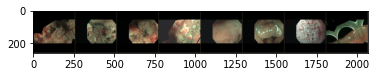

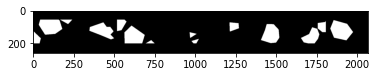

In [ ]:
# Visualize some examples

iterator = iter(train_loader)
data = next(iterator)

inputs = data['image']
masks = data['mask']

print(inputs.shape)
print(masks.shape)

ins = torchvision.utils.make_grid(inputs)
imshow(ins)
out = torchvision.utils.make_grid(masks)
maskshow(out)

### **Model Architecture (UNET)**

**U-Net**

In [ ]:
## UNet Model
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
      super(DoubleConv, self).__init__()
      self.conv = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
          nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
      )

  def forward(self, x):
    return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 1, features = [64,128,256,512,1024]):
      super(UNET, self).__init__()
      self.downs = nn.ModuleList()
      self.ups = nn.ModuleList()
      self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

      # Down Part of UNET
      for feature in features:
        self.downs.append(DoubleConv(in_channels, feature))
        in_channels = feature

      # Up Part of UNET
      for feature in reversed(features):
        self.ups.append(
            nn.ConvTranspose2d(
                feature*2, feature, kernel_size=2, stride=2
            )
        )

        self.ups.append(DoubleConv(feature*2, feature))

      self.bottleneck = DoubleConv(features[-1], features[-1]*2)
      self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
      skip_connections = []

      for down in self.downs:
        x = down(x)
        skip_connections.append(x)
        x = self.pool(x)

      x = self.bottleneck(x)
      skip_connections = skip_connections[::-1]
      for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

      return self.final_conv(x)

### **Training and Testing**

In [ ]:
# Hyperparameters

LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-8
MOMENTUM = 0.9
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_EPOCHS = 100
N_CHANNELS = 3
N_CLASSES = 1
LR_PATIENCE = 5 #Learning Rate Patience
ES_PATIENCE = 10 #Early Stopping Patience Patience

**Testing**

In [ ]:
# Evalute the average dice score and the loss for all the images in a dataloader
def evaluate(net, dataloader, criterion, device):

    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    loss = 0

    with tqdm(total=num_val_batches , desc=f'Valid', unit='img') as pbar:
      for batch in dataloader:
        image, gt = batch['image'], batch['mask']

        image = image.to(device=device, dtype=torch.float32)
        gt = gt.unsqueeze(1).to(device=device)

        with torch.no_grad():

          pred = net(image)
          pbar.update(image.shape[0])
          loss_b = criterion(pred.view(-1), gt.view(-1))
          loss += loss_b

          d = get_dice(pred, gt)
          dice_score += d
        pbar.set_postfix(**{'dice ': d.item(), 'loss ': loss.item()})

    net.train()

    if num_val_batches == 0:
        return dice_score, loss
    dice_score_avg = dice_score / num_val_batches
    loss_avg = loss / num_val_batches
    return dice_score_avg.cpu() , loss_avg.cpu()

In [ ]:
def predict(image, model, threshold):
  image = image.unsqueeze(0).float().to(DEVICE)
  preds = torch.sigmoid(model(image))
  preds = (preds > threshold).int()

  preds = preds[0, :, :, :]
  preds = preds.cpu().numpy().transpose((1, 2, 0))*255

  return preds.squeeze(axis=2)

**Training**

In [ ]:
# function to train a model
def train_net(net,
              device,
              train_loader,
              val_loader,
              early_stop_patience,
              optimizer,
              grad_scaler,
              scheduler,
              criterion,
              epochs: int = 5,
              save_checkpoint: bool = True,
              checkpoint_path= '',
              model='',
              amp: bool = False):

    best_val_dice = 0.0
    best_parameters = net.state_dict()
    early_stop_count = 0

    # Begin training
    for epoch in range(epochs):
        net.train()
        epoch_loss = 0
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images = batch['image']
                masks = batch['mask']

                images = images.to(device=device, dtype=torch.float32)
                gt = masks.to(device=device, dtype=torch.float32)

                with torch.cuda.amp.autocast(enabled=amp):
                    pred = net(images)
                    loss = criterion(pred, gt)

                optimizer.zero_grad()
                grad_scaler.scale(loss).backward()
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])

                epoch_loss += loss.item()
                pbar.set_postfix(**{'loss (batch)': loss.item()})

        print(f"Training Loss: {epoch_loss/len(train_loader):.5f}")


        val_dice, val_loss = evaluate(net, val_loader, criterion, device)

        train_loss = epoch_loss/len(train_loader)

        scheduler.step(val_loss)
        print(f'Val Dice: {val_dice:.4f}, Val Loss: {val_loss:.4f}')

        y_loss['train'].append(train_loss)
        y_loss['val'].append(val_loss)
        y_dice.append(val_dice)

        draw_curve(epoch, model)

        if val_dice > best_val_dice:
            best_val_dice = val_dice
            best_parameters = copy.deepcopy(net.state_dict())
            early_stop_count = 0
        else:
          early_stop_count += 1

        if early_stop_count > early_stop_patience:
          print(f"EARLY STOPPING AFTER {epoch+1} EPOCHS")
          break

        print("\n")

    # save the weight of the model that gave the best validation results
    if save_checkpoint:
        torch.save(best_parameters, checkpoint_path)

# **Start Training**

## **UNET**

### **DiceBCE Loss + Adam**

In [ ]:
# Checkpoints
CHECKPOINT_UNET_DiceBCE_ADAM = '/content/drive/MyDrive/Colab Notebooks/ENDO/Models/unet_dicebce_adam.pth'
# CHECKPOINT_UNET_DiceBCE_ADAM = parent_directory + "Models/unet_dicebce_adam.pth"
MODEL_UNET_DiceBCE_ADAM = 'unet_dicebce_adam'

# create a new U-Net model
unet_dicebce_adam = UNET(in_channels=N_CHANNELS, out_channels=N_CLASSES).to(DEVICE)

# Optimizer
optimizer = optim.Adam(unet_dicebce_adam.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=LR_PATIENCE)

# Gradient scaler
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = LossDICEBCE()

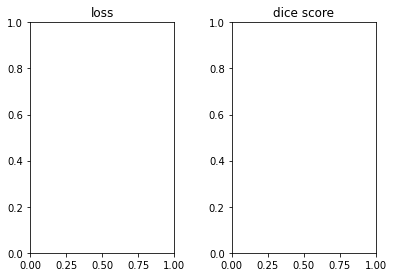

In [ ]:
#Paramteres for Graph
y_loss = {}  # loss history
y_loss['train'] = []
y_loss['val'] = []

y_dice = []
x_epoch = []

fig = plt.figure()
ax0 = fig.add_subplot(121, title="loss")
ax1 = fig.add_subplot(122, title="dice score")

# set the spacing between subplots
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

In [ ]:
train_net(unet_dicebce_adam, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, # gradient optimizer
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function to be minimized
          NUM_EPOCHS, # number of epochs
          True, # whether to save the final model asa file  or not
          CHECKPOINT_UNET_DiceBCE_ADAM , # where to save the model
          MODEL_UNET_DiceBCE_ADAM,
          amp = True) # Activate Cuda automatic mixed precision flag

Epoch 1/100: 746img [01:04, 11.58img/s, loss (batch)=1.21]


Training Loss: 1.23169


Valid: 187img [00:14, 12.48img/s, dice =0.152, loss =25.5]


Val Dice: 0.3526, Val Loss: 1.0607




Epoch 2/100: 746img [01:03, 11.72img/s, loss (batch)=1.06]


Training Loss: 1.02484


Valid: 187img [00:14, 12.53img/s, dice =0.183, loss =22.3]


Val Dice: 0.4091, Val Loss: 0.9282




Epoch 3/100: 746img [01:03, 11.78img/s, loss (batch)=0.877]


Training Loss: 0.93657


Valid: 187img [00:14, 12.61img/s, dice =0.21, loss =21.3]


Val Dice: 0.4258, Val Loss: 0.8887




Epoch 4/100: 746img [01:00, 12.29img/s, loss (batch)=1.02]


Training Loss: 0.88480


Valid: 187img [00:18, 10.06img/s, dice =0.205, loss =21.2]


Val Dice: 0.4509, Val Loss: 0.8846




Epoch 5/100: 746img [01:01, 12.05img/s, loss (batch)=0.79]


Training Loss: 0.84161


Valid: 187img [00:16, 11.29img/s, dice =0.213, loss =20]


Val Dice: 0.4535, Val Loss: 0.8342




Epoch 6/100: 746img [01:01, 12.21img/s, loss (batch)=0.677]


Training Loss: 0.79995


Valid: 187img [00:14, 12.57img/s, dice =0.253, loss =20.3]


Val Dice: 0.4610, Val Loss: 0.8445




Epoch 7/100: 746img [01:02, 11.95img/s, loss (batch)=1.07]


Training Loss: 0.77189


Valid: 187img [00:14, 12.62img/s, dice =0.251, loss =19.9]


Val Dice: 0.4808, Val Loss: 0.8306




Epoch 8/100: 746img [01:02, 11.87img/s, loss (batch)=0.648]


Training Loss: 0.74072


Valid: 187img [00:14, 12.59img/s, dice =0.201, loss =19.4]


Val Dice: 0.4488, Val Loss: 0.8072




Epoch 9/100: 746img [01:02, 11.96img/s, loss (batch)=0.907]


Training Loss: 0.70194


Valid: 187img [00:16, 11.24img/s, dice =0.225, loss =19.4]


Val Dice: 0.4725, Val Loss: 0.8074




Epoch 10/100: 746img [01:02, 11.86img/s, loss (batch)=0.621]


Training Loss: 0.67356


Valid: 187img [00:14, 12.56img/s, dice =0.226, loss =19.2]


Val Dice: 0.4638, Val Loss: 0.8016




Epoch 11/100: 746img [01:00, 12.25img/s, loss (batch)=0.967]


Training Loss: 0.64687


Valid: 187img [00:16, 11.20img/s, dice =0.257, loss =19.3]


Val Dice: 0.4678, Val Loss: 0.8042




Epoch 12/100: 746img [01:00, 12.24img/s, loss (batch)=0.526]


Training Loss: 0.62076


Valid: 187img [00:16, 11.30img/s, dice =0.273, loss =19]


Val Dice: 0.4879, Val Loss: 0.7931




Epoch 13/100: 746img [01:01, 12.15img/s, loss (batch)=0.669]


Training Loss: 0.61110


Valid: 187img [00:14, 12.60img/s, dice =0.261, loss =18.8]


Val Dice: 0.4815, Val Loss: 0.7815




Epoch 14/100: 746img [01:02, 11.93img/s, loss (batch)=0.467]


Training Loss: 0.58685


Valid: 187img [00:16, 11.28img/s, dice =0.283, loss =18.9]


Val Dice: 0.4994, Val Loss: 0.7883




Epoch 15/100: 746img [01:03, 11.76img/s, loss (batch)=0.597]


Training Loss: 0.57344


Valid: 187img [00:18, 10.39img/s, dice =0.281, loss =18.7]


Val Dice: 0.4980, Val Loss: 0.7794




Epoch 16/100: 746img [01:02, 11.88img/s, loss (batch)=0.565]


Training Loss: 0.56929


Valid: 187img [00:16, 11.64img/s, dice =0.26, loss =18.9]


Val Dice: 0.4695, Val Loss: 0.7878




Epoch 17/100: 746img [01:03, 11.77img/s, loss (batch)=0.644]


Training Loss: 0.55352


Valid: 187img [00:14, 12.52img/s, dice =0.268, loss =18.7]


Val Dice: 0.4954, Val Loss: 0.7796




Epoch 18/100: 746img [01:03, 11.80img/s, loss (batch)=0.952]


Training Loss: 0.54905


Valid: 187img [00:14, 12.52img/s, dice =0.292, loss =18.4]


Val Dice: 0.4995, Val Loss: 0.7651




Epoch 19/100: 746img [01:03, 11.66img/s, loss (batch)=0.533]


Training Loss: 0.54549


Valid: 187img [00:14, 12.71img/s, dice =0.297, loss =18.2]


Val Dice: 0.5024, Val Loss: 0.7584




Epoch 20/100: 746img [01:00, 12.26img/s, loss (batch)=0.484]


Training Loss: 0.51740


Valid: 187img [00:14, 12.64img/s, dice =0.304, loss =17.9]


Val Dice: 0.5116, Val Loss: 0.7462




Epoch 21/100: 746img [01:03, 11.78img/s, loss (batch)=0.376]


Training Loss: 0.50416


Valid: 187img [00:16, 11.34img/s, dice =0.298, loss =17.8]


Val Dice: 0.5205, Val Loss: 0.7428




Epoch 22/100: 746img [01:01, 12.08img/s, loss (batch)=0.45]


Training Loss: 0.49459


Valid: 187img [00:14, 12.61img/s, dice =0.288, loss =18.2]


Val Dice: 0.4987, Val Loss: 0.7581




Epoch 23/100: 746img [01:02, 11.97img/s, loss (batch)=0.348]


Training Loss: 0.48064


Valid: 187img [00:14, 12.84img/s, dice =0.305, loss =17.6]


Val Dice: 0.5299, Val Loss: 0.7349




Epoch 24/100: 746img [01:02, 11.91img/s, loss (batch)=0.329]


Training Loss: 0.47644


Valid: 187img [00:15, 11.95img/s, dice =0.313, loss =17.8]


Val Dice: 0.5370, Val Loss: 0.7400




Epoch 25/100: 746img [01:02, 12.01img/s, loss (batch)=0.427]


Training Loss: 0.46543


Valid: 187img [00:14, 12.76img/s, dice =0.309, loss =17.5]


Val Dice: 0.5280, Val Loss: 0.7300




Epoch 26/100: 746img [01:02, 12.03img/s, loss (batch)=0.401]


Training Loss: 0.45691


Valid: 187img [00:14, 12.72img/s, dice =0.315, loss =17.8]


Val Dice: 0.5220, Val Loss: 0.7415




Epoch 27/100: 746img [01:00, 12.29img/s, loss (batch)=0.373]


Training Loss: 0.45144


Valid: 187img [00:15, 12.39img/s, dice =0.31, loss =17.4]


Val Dice: 0.5318, Val Loss: 0.7263




Epoch 28/100: 746img [01:01, 12.15img/s, loss (batch)=0.371]


Training Loss: 0.44168


Valid: 187img [00:16, 11.42img/s, dice =0.31, loss =17.4]


Val Dice: 0.5363, Val Loss: 0.7231




Epoch 29/100: 746img [01:00, 12.28img/s, loss (batch)=0.686]


Training Loss: 0.43626


Valid: 187img [00:16, 11.55img/s, dice =0.326, loss =17.4]


Val Dice: 0.5371, Val Loss: 0.7248




Epoch 30/100: 746img [01:02, 12.01img/s, loss (batch)=0.442]


Training Loss: 0.42147


Valid: 187img [00:14, 12.80img/s, dice =0.332, loss =17.2]


Val Dice: 0.5466, Val Loss: 0.7168




Epoch 31/100: 746img [01:02, 12.00img/s, loss (batch)=0.584]


Training Loss: 0.41639


Valid: 187img [00:14, 12.74img/s, dice =0.326, loss =17.3]


Val Dice: 0.5400, Val Loss: 0.7190




Epoch 32/100: 746img [01:02, 11.95img/s, loss (batch)=0.607]


Training Loss: 0.41042


Valid: 187img [00:14, 12.74img/s, dice =0.337, loss =17.8]


Val Dice: 0.5255, Val Loss: 0.7402




Epoch 33/100: 746img [01:02, 11.96img/s, loss (batch)=0.676]


Training Loss: 0.40698


Valid: 187img [00:14, 12.72img/s, dice =0.346, loss =17.2]


Val Dice: 0.5431, Val Loss: 0.7158




Epoch 34/100: 746img [01:00, 12.33img/s, loss (batch)=0.595]


Training Loss: 0.40051


Valid: 187img [00:17, 10.42img/s, dice =0.32, loss =17]


Val Dice: 0.5458, Val Loss: 0.7069




Epoch 35/100: 746img [01:02, 12.00img/s, loss (batch)=0.331]


Training Loss: 0.39176


Valid: 187img [00:14, 12.73img/s, dice =0.304, loss =16.8]


Val Dice: 0.5462, Val Loss: 0.7010




Epoch 36/100: 746img [01:00, 12.31img/s, loss (batch)=0.414]


Training Loss: 0.38223


Valid: 187img [00:14, 12.73img/s, dice =0.323, loss =17]


Val Dice: 0.5427, Val Loss: 0.7064




Epoch 37/100: 746img [01:02, 11.99img/s, loss (batch)=0.376]


Training Loss: 0.37729


Valid: 187img [00:14, 12.67img/s, dice =0.328, loss =17.8]


Val Dice: 0.5400, Val Loss: 0.7399




Epoch 38/100: 746img [01:02, 12.02img/s, loss (batch)=0.333]


Training Loss: 0.41929


Valid: 187img [00:14, 12.65img/s, dice =0.308, loss =17.4]


Val Dice: 0.5210, Val Loss: 0.7246




Epoch 39/100: 746img [01:02, 12.02img/s, loss (batch)=0.403]


Training Loss: 0.40046


Valid: 187img [00:16, 11.37img/s, dice =0.29, loss =17.5]


Val Dice: 0.5257, Val Loss: 0.7301




Epoch 40/100: 746img [01:02, 12.01img/s, loss (batch)=0.367]


Training Loss: 0.37040


Valid: 187img [00:14, 12.69img/s, dice =0.309, loss =17.2]


Val Dice: 0.5285, Val Loss: 0.7173




Epoch 41/100: 746img [01:02, 11.99img/s, loss (batch)=0.253]


Training Loss: 0.35119


Valid: 187img [00:14, 12.69img/s, dice =0.337, loss =16.5]


Val Dice: 0.5629, Val Loss: 0.6875




Epoch 42/100: 746img [01:02, 11.88img/s, loss (batch)=0.237]


Training Loss: 0.34072


Valid: 187img [00:14, 12.82img/s, dice =0.324, loss =16.7]


Val Dice: 0.5540, Val Loss: 0.6956




Epoch 43/100: 746img [01:00, 12.28img/s, loss (batch)=0.306]


Training Loss: 0.33515


Valid: 187img [00:14, 12.66img/s, dice =0.338, loss =16.5]


Val Dice: 0.5547, Val Loss: 0.6871




Epoch 44/100: 746img [01:03, 11.73img/s, loss (batch)=0.493]


Training Loss: 0.33010


Valid: 187img [00:16, 11.47img/s, dice =0.365, loss =16.6]


Val Dice: 0.5700, Val Loss: 0.6929




Epoch 45/100: 746img [01:00, 12.24img/s, loss (batch)=0.276]


Training Loss: 0.32440


Valid: 187img [00:14, 12.73img/s, dice =0.338, loss =16.1]


Val Dice: 0.5755, Val Loss: 0.6705




Epoch 46/100: 746img [01:02, 11.96img/s, loss (batch)=0.284]


Training Loss: 0.31786


Valid: 187img [00:14, 12.79img/s, dice =0.386, loss =16.4]


Val Dice: 0.5831, Val Loss: 0.6844




Epoch 47/100: 746img [01:02, 11.99img/s, loss (batch)=0.33]


Training Loss: 0.31091


Valid: 187img [00:14, 12.89img/s, dice =0.366, loss =16.5]


Val Dice: 0.5600, Val Loss: 0.6863




Epoch 48/100: 746img [01:02, 11.94img/s, loss (batch)=0.257]


Training Loss: 0.30823


Valid: 187img [00:14, 12.76img/s, dice =0.394, loss =18.8]


Val Dice: 0.5944, Val Loss: 0.7827




Epoch 49/100: 746img [01:04, 11.61img/s, loss (batch)=0.226]


Training Loss: 0.35041


Valid: 187img [00:14, 12.64img/s, dice =0.393, loss =15.7]


Val Dice: 0.5756, Val Loss: 0.6522




Epoch 50/100: 746img [01:00, 12.27img/s, loss (batch)=0.58]


Training Loss: 0.31720


Valid: 187img [00:16, 11.54img/s, dice =0.365, loss =15.8]


Val Dice: 0.5878, Val Loss: 0.6574




Epoch 51/100: 746img [01:01, 12.16img/s, loss (batch)=0.305]


Training Loss: 0.30742


Valid: 187img [00:14, 12.91img/s, dice =0.415, loss =16.5]


Val Dice: 0.5857, Val Loss: 0.6865




Epoch 52/100: 746img [00:59, 12.53img/s, loss (batch)=0.212]


Training Loss: 0.29027


Valid: 187img [00:14, 12.93img/s, dice =0.432, loss =15.9]


Val Dice: 0.5815, Val Loss: 0.6636




Epoch 53/100: 746img [01:02, 12.03img/s, loss (batch)=0.333]


Training Loss: 0.28324


Valid: 187img [00:14, 12.81img/s, dice =0.427, loss =15.7]


Val Dice: 0.5789, Val Loss: 0.6562




Epoch 54/100: 746img [01:03, 11.75img/s, loss (batch)=0.204]


Training Loss: 0.28101


Valid: 187img [00:14, 12.87img/s, dice =0.37, loss =15.3]


Val Dice: 0.6111, Val Loss: 0.6387




Epoch 55/100: 746img [01:01, 12.04img/s, loss (batch)=0.477]


Training Loss: 0.29588


Valid: 187img [00:14, 12.99img/s, dice =0.354, loss =16.5]


Val Dice: 0.5760, Val Loss: 0.6859




Epoch 56/100: 746img [01:01, 12.12img/s, loss (batch)=0.244]


Training Loss: 0.28138


Valid: 187img [00:14, 12.94img/s, dice =0.437, loss =16]


Val Dice: 0.5809, Val Loss: 0.6686




Epoch 57/100: 746img [01:01, 12.21img/s, loss (batch)=0.169]


Training Loss: 0.26689


Valid: 187img [00:14, 12.91img/s, dice =0.414, loss =16.2]


Val Dice: 0.5713, Val Loss: 0.6744




Epoch 58/100: 746img [01:01, 12.14img/s, loss (batch)=0.186]


Training Loss: 0.25736


Valid: 187img [00:14, 12.91img/s, dice =0.419, loss =15.7]


Val Dice: 0.5904, Val Loss: 0.6525




Epoch 59/100: 746img [01:01, 12.11img/s, loss (batch)=0.227]


Training Loss: 0.25024


Valid: 187img [00:14, 12.90img/s, dice =0.395, loss =15.8]


Val Dice: 0.5947, Val Loss: 0.6563




Epoch 60/100: 746img [01:01, 12.05img/s, loss (batch)=0.263]


Training Loss: 0.24544


Valid: 187img [00:16, 11.62img/s, dice =0.41, loss =15.4]


Val Dice: 0.6060, Val Loss: 0.6434




Epoch 61/100: 746img [01:00, 12.31img/s, loss (batch)=0.224]


Training Loss: 0.24084


Valid: 187img [00:14, 12.91img/s, dice =0.427, loss =15.6]


Val Dice: 0.6021, Val Loss: 0.6480




Epoch 62/100: 746img [01:01, 12.20img/s, loss (batch)=0.57]


Training Loss: 0.24258


Valid: 187img [00:14, 13.07img/s, dice =0.422, loss =15.7]


Val Dice: 0.6031, Val Loss: 0.6554




Epoch 63/100: 746img [01:02, 11.89img/s, loss (batch)=0.237]


Training Loss: 0.24010


Valid: 187img [00:14, 12.95img/s, dice =0.424, loss =15.5]


Val Dice: 0.6003, Val Loss: 0.6464




Epoch 64/100: 746img [01:03, 11.78img/s, loss (batch)=0.133]


Training Loss: 0.23761


Valid: 187img [00:14, 12.85img/s, dice =0.426, loss =15.5]


Val Dice: 0.6072, Val Loss: 0.6456




Epoch 65/100: 746img [01:01, 12.13img/s, loss (batch)=0.193]


Training Loss: 0.23652


Valid: 187img [00:14, 12.90img/s, dice =0.429, loss =15.5]


Val Dice: 0.6049, Val Loss: 0.6462
EARLY STOPPING AFTER 65 EPOCHS


In [ ]:
# Load the best weights obtained to the model
unet_dicebce_adam.load_state_dict(torch.load(CHECKPOINT_UNET_DiceBCE_ADAM))
unet_dicebce_adam.eval()

UNET(
  (downs): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=T

In [ ]:
#Intermediate function that only takes the threshold as parameter and returns the jaccard score
def jaccard(th):
  return check_js(val_loader, unet_dicebce_adam, threshold= th, device=DEVICE)

In [ ]:
pbounds = {'th': (0, 1)} # Search interval
optimizer = BayesianOptimization(
    f=jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(
    init_points=5, # perform 2 steps of random exploration
    n_iter=15, # Perform 15 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.3762   |  0.3745   |
|  2        |  0.3524   |  0.9507   |
|  3        |  0.3693   |  0.732    |
|  4        |  0.3725   |  0.5987   |
|  5        |  0.3824   |  0.156    |
|  6        |  0.1238   |  0.0      |
|  7        |  0.3693   |  0.732    |
|  8        |  0.3788   |  0.2537   |
|  9        |  0.3745   |  0.4857   |
|  10       |  0.3649   |  0.8393   |
|  11       |  0.3712   |  0.6643   |
|  12       |  0.3805   |  0.2001   |
|  13       |  0.0      |  1.0      |
|  14       |  0.36     |  0.9036   |
|  15       |  0.3753   |  0.4296   |
|  16       |  0.3773   |  0.3135   |
|  17       |  0.3735   |  0.5421   |
|  18       |  0.3848   |  0.1028   |
|  19       |  0.3673   |  0.7876   |
|  20       |  0.305    |  0.06699  |


In [ ]:
# retrieve the threshold that gave the best result on the validation set
th_unet_dicebce_adam = optimizer.max['params']['th']
print(f"The optimal threshold is {th_unet_dicebce_adam:.4f}")

The optimal threshold is 0.1028


In [ ]:
dice, loss = evaluate(unet_dicebce_adam, val_loader, criterion, DEVICE)
jacc = check_js(val_loader, unet_dicebce_adam, threshold= th_unet_dicebce_adam, device=DEVICE)
print("Model: UNET, Optimizer: Adam, Loss: DiceBCE")
print(f'Validation Dice: {dice:.4f}')
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Jaccard: {jacc:.4f}')

Valid: 187img [00:15, 12.44img/s, dice =0.587, loss =23.2]


Model: UNET, Optimizer: Adam, Loss: DiceBCE
Validation Dice: 0.4569
Validation Loss: 0.9684
Validation Jaccard: 0.3848


In [ ]:
jacc = check_js_original_size(val_loader,
                              unet_dicebce_adam,
                              mask_folder = Val_mask_folder,
                              threshold= th_unet_dicebce_adam,
                              device=DEVICE)

print(f'Test Jaccard (original size): {jacc:.4f}')

Test Jaccard (original size): 0.5581


### **Dice Loss + Adam**

In [ ]:
# Checkpoints
CHECKPOINT_UNET_Dice_ADAM = '/content/drive/MyDrive/Colab Notebooks/ENDO/Models/unet_dice_adam.pth'
# CHECKPOINT_UNET_Dice_ADAM = parent_directory + "Models/unet_dice_adam.pth"
MODEL_UNET_Dice_ADAM = 'unet_dice_adam'

# create a new U-Net model
unet_dice_adam = UNET(in_channels=N_CHANNELS, out_channels=N_CLASSES).to(DEVICE)

# Optimizer
optimizer = optim.Adam(unet_dice_adam.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=LR_PATIENCE)

# Gradient scaler
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = LossDICE()

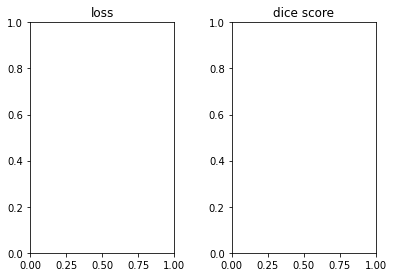

In [ ]:
#Paramteres for Graph
y_loss = {}  # loss history
y_loss['train'] = []
y_loss['val'] = []

y_dice = []
x_epoch = []

fig = plt.figure()
ax0 = fig.add_subplot(121, title="loss")
ax1 = fig.add_subplot(122, title="dice score")

# set the spacing between subplots
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

In [ ]:
train_net(unet_dice_adam, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, # gradient optimizer
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function to be minimized
          NUM_EPOCHS, # number of epochs
          True, # whether to save the final model asa file  or not
          CHECKPOINT_UNET_Dice_ADAM , # where to save the model
          MODEL_UNET_Dice_ADAM,
          amp = True) # Activate Cuda automatic mixed precision flag

Epoch 1/100: 746img [04:36,  2.70img/s, loss (batch)=0.796]


Training Loss: 0.74207


Valid: 187img [00:15, 12.09img/s, dice =0.471, loss =16.1]


Val Dice: 0.3312, Val Loss: 0.6688




Epoch 2/100: 746img [01:04, 11.53img/s, loss (batch)=0.725]


Training Loss: 0.65730


Valid: 187img [00:15, 12.10img/s, dice =0.512, loss =14.8]


Val Dice: 0.3839, Val Loss: 0.6161




Epoch 3/100: 746img [01:02, 11.91img/s, loss (batch)=0.584]


Training Loss: 0.63463


Valid: 187img [00:15, 12.42img/s, dice =0.49, loss =14.8]


Val Dice: 0.3848, Val Loss: 0.6152




Epoch 4/100: 746img [01:02, 11.86img/s, loss (batch)=0.616]


Training Loss: 0.62285


Valid: 187img [00:15, 12.08img/s, dice =0.503, loss =14.6]


Val Dice: 0.3915, Val Loss: 0.6085




Epoch 5/100: 746img [01:01, 12.06img/s, loss (batch)=0.607]


Training Loss: 0.61506


Valid: 187img [00:15, 12.46img/s, dice =0.495, loss =14.5]


Val Dice: 0.3943, Val Loss: 0.6057




Epoch 6/100: 746img [01:02, 11.97img/s, loss (batch)=0.452]


Training Loss: 0.60602


Valid: 187img [00:15, 12.42img/s, dice =0.485, loss =14.6]


Val Dice: 0.3936, Val Loss: 0.6064




Epoch 7/100: 746img [01:02, 11.98img/s, loss (batch)=0.524]


Training Loss: 0.59778


Valid: 187img [00:15, 12.36img/s, dice =0.515, loss =14.3]


Val Dice: 0.4030, Val Loss: 0.5970




Epoch 8/100: 746img [01:02, 11.98img/s, loss (batch)=0.601]


Training Loss: 0.58665


Valid: 187img [00:15, 12.32img/s, dice =0.495, loss =14.4]


Val Dice: 0.3996, Val Loss: 0.6004




Epoch 9/100: 746img [01:02, 12.00img/s, loss (batch)=0.377]


Training Loss: 0.57522


Valid: 187img [00:14, 12.51img/s, dice =0.516, loss =14.4]


Val Dice: 0.4012, Val Loss: 0.5988




Epoch 10/100: 746img [01:02, 12.03img/s, loss (batch)=0.711]


Training Loss: 0.56464


Valid: 187img [00:15, 12.38img/s, dice =0.547, loss =14.4]


Val Dice: 0.3997, Val Loss: 0.6003




Epoch 11/100: 746img [01:02, 12.00img/s, loss (batch)=0.571]


Training Loss: 0.55164


Valid: 187img [00:15, 12.36img/s, dice =0.446, loss =14.9]


Val Dice: 0.3787, Val Loss: 0.6213




Epoch 12/100: 746img [01:02, 12.02img/s, loss (batch)=0.328]


Training Loss: 0.53538


Valid: 187img [00:15, 12.44img/s, dice =0.529, loss =14.7]


Val Dice: 0.3870, Val Loss: 0.6130




Epoch 13/100: 746img [01:01, 12.07img/s, loss (batch)=0.539]


Training Loss: 0.52268


Valid: 187img [00:15, 12.33img/s, dice =0.464, loss =14.8]


Val Dice: 0.3843, Val Loss: 0.6157




Epoch 14/100: 746img [01:01, 12.07img/s, loss (batch)=0.447]


Training Loss: 0.49947


Valid: 187img [00:15, 12.38img/s, dice =0.441, loss =15.1]


Val Dice: 0.3692, Val Loss: 0.6308




Epoch 15/100: 746img [01:02, 12.00img/s, loss (batch)=0.29]


Training Loss: 0.48910


Valid: 187img [00:15, 12.27img/s, dice =0.438, loss =15.3]


Val Dice: 0.3629, Val Loss: 0.6371




Epoch 16/100: 746img [01:01, 12.04img/s, loss (batch)=0.515]


Training Loss: 0.48418


Valid: 187img [00:15, 12.35img/s, dice =0.426, loss =15.4]


Val Dice: 0.3598, Val Loss: 0.6402




Epoch 17/100: 746img [01:01, 12.09img/s, loss (batch)=0.593]


Training Loss: 0.48257


Valid: 187img [00:14, 12.51img/s, dice =0.399, loss =15.6]


Val Dice: 0.3514, Val Loss: 0.6486




Epoch 18/100: 746img [01:01, 12.10img/s, loss (batch)=0.551]


Training Loss: 0.47943


Valid: 187img [00:15, 12.37img/s, dice =0.415, loss =15.5]


Val Dice: 0.3534, Val Loss: 0.6466
EARLY STOPPING AFTER 18 EPOCHS


In [ ]:
# Load the best weights obtained to the model
unet_dice_adam.load_state_dict(torch.load(CHECKPOINT_UNET_Dice_ADAM))
unet_dice_adam.eval()

UNET(
  (downs): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=T

In [ ]:
#Intermediate function that only takes the threshold as parameter and returns the jaccard score
def jaccard(th):
  return check_js(val_loader, unet_dice_adam, threshold= th, device=DEVICE)

In [ ]:
pbounds = {'th': (0, 1)} # Search interval
optimizer = BayesianOptimization(
    f=jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(
    init_points=5, # perform 2 steps of random exploration
    n_iter=15, # Perform 15 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.3337   |  0.3745   |
|  2        |  0.3466   |  0.9507   |
|  3        |  0.35     |  0.732    |
|  4        |  0.349    |  0.5987   |
|  5        |  0.249    |  0.156    |
|  6        |  0.3505   |  0.8444   |
|  7        |  0.35     |  0.732    |
|  8        |  0.3487   |  0.4881   |
|  9        |  0.0      |  1.0      |
|  10       |  0.3494   |  0.9145   |
|  11       |  0.3489   |  0.5458   |
|  12       |  0.3503   |  0.7946   |
|  13       |  0.3455   |  0.4365   |
|  14       |  0.3494   |  0.6537   |
|  15       |  0.3124   |  0.3123   |
|  16       |  0.1238   |  0.0      |
|  17       |  0.2867   |  0.2464   |
|  18       |  0.3496   |  0.6907   |
|  19       |  0.1241   |  0.08737  |
|  20       |  0.3501   |  0.8773   |


In [ ]:
# retrieve the threshold that gave the best result on the validation set
th_unet_dice_adam = optimizer.max['params']['th']
print(f"The optimal threshold is {th_unet_dice_adam:.4f}")

The optimal threshold is 0.8444


In [ ]:
dice, loss = evaluate(unet_dice_adam, val_loader, criterion, DEVICE)
jacc = check_js(val_loader, unet_dice_adam, threshold= th_unet_dice_adam, device=DEVICE)
print("Model: UNET, Optimizer: Adam, Loss: Dice")
print(f'Validation Dice: {dice:.4f}')
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Jaccard: {jacc:.4f}')

Valid: 187img [00:15, 11.98img/s, dice =0.515, loss =14.3]


Model: UNET, Optimizer: Adam, Loss: Dice
Validation Dice: 0.4030
Validation Loss: 0.5970
Validation Jaccard: 0.3505


In [ ]:
jacc = check_js_original_size(val_loader,
                              unet_dice_adam,
                              mask_folder = Val_mask_folder,
                              threshold= th_unet_dice_adam,
                              device=DEVICE)

print(f'Test Jaccard (original size): {jacc:.4f}')

Test Jaccard (original size): 0.3691


### **IOU Loss + Adam**

In [ ]:
# Checkpoints
CHECKPOINT_UNET_IOU_ADAM = '/content/drive/MyDrive/Colab Notebooks/ENDO/Models/unet_iou_adam.pth'
# CHECKPOINT_UNET_IOU_ADAM = parent_directory + "Models/unet_iou_adam.pth"
MODEL_UNET_IOU_ADAM = 'unet_iou_adam'

# create a new U-Net model
unet_iou_adam = UNET(in_channels=N_CHANNELS, out_channels=N_CLASSES).to(DEVICE)

# Optimizer
optimizer = optim.Adam(unet_iou_adam.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=LR_PATIENCE)

# Gradient scaler
grad_scaler = torch.cuda.amp.GradScaler()

# Loss function
criterion = IoULoss()

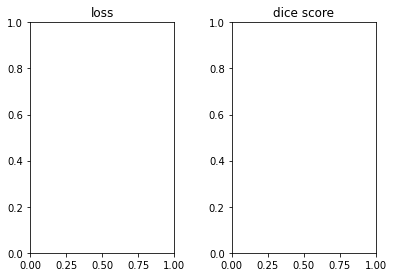

In [ ]:
#Paramteres for Graph
y_loss = {}  # loss history
y_loss['train'] = []
y_loss['val'] = []

y_dice = []
x_epoch = []

fig = plt.figure()
ax0 = fig.add_subplot(121, title="loss")
ax1 = fig.add_subplot(122, title="dice score")


# set the spacing between subplots
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

In [ ]:
train_net(unet_iou_adam, # the model to be trained
          DEVICE, # cuda or cpu
          train_loader,  # training dataloader
          val_loader, # validation data loader
          ES_PATIENCE, # stop training if val loss does not improve after this much steps
          optimizer, # gradient optimizer
          grad_scaler,# gradient scaler
          scheduler, # learning rate scheduler
          criterion, # Objectve/loss function to be minimized
          NUM_EPOCHS, # number of epochs
          True, # whether to save the final model asa file  or not
          CHECKPOINT_UNET_IOU_ADAM , # where to save the model
          MODEL_UNET_IOU_ADAM,
          amp = True) # Activate Cuda automatic mixed precision flag

Epoch 1/100: 746img [01:05, 11.34img/s, loss (batch)=0.726]


Training Loss: 0.84881


Valid: 187img [00:15, 11.85img/s, dice =0.461, loss =19.1]


Val Dice: 0.3287, Val Loss: 0.7970




Epoch 2/100: 746img [01:06, 11.21img/s, loss (batch)=0.65]


Training Loss: 0.80454


Valid: 187img [00:15, 12.35img/s, dice =0.478, loss =18.6]


Val Dice: 0.3556, Val Loss: 0.7766




Epoch 3/100: 746img [01:04, 11.60img/s, loss (batch)=0.79]


Training Loss: 0.79322


Valid: 187img [00:15, 12.05img/s, dice =0.49, loss =18.5]


Val Dice: 0.3635, Val Loss: 0.7705




Epoch 4/100: 746img [01:02, 11.92img/s, loss (batch)=0.831]


Training Loss: 0.78589


Valid: 187img [00:15, 11.75img/s, dice =0.466, loss =18.6]


Val Dice: 0.3575, Val Loss: 0.7754




Epoch 5/100: 746img [01:05, 11.40img/s, loss (batch)=0.816]


Training Loss: 0.77969


Valid: 187img [00:16, 11.68img/s, dice =0.458, loss =18.5]


Val Dice: 0.3617, Val Loss: 0.7720




Epoch 6/100: 746img [01:05, 11.37img/s, loss (batch)=0.685]


Training Loss: 0.77266


Valid: 187img [00:16, 11.60img/s, dice =0.449, loss =18.5]


Val Dice: 0.3638, Val Loss: 0.7702




Epoch 7/100: 746img [01:06, 11.23img/s, loss (batch)=0.824]


Training Loss: 0.76802


Valid: 187img [00:16, 11.50img/s, dice =0.416, loss =19]


Val Dice: 0.3347, Val Loss: 0.7933




Epoch 8/100: 746img [01:03, 11.81img/s, loss (batch)=0.766]


Training Loss: 0.76021


Valid: 187img [00:15, 12.36img/s, dice =0.515, loss =18.2]


Val Dice: 0.3775, Val Loss: 0.7593




Epoch 9/100: 746img [01:02, 11.98img/s, loss (batch)=0.776]


Training Loss: 0.75355


Valid: 187img [00:15, 12.28img/s, dice =0.411, loss =19]


Val Dice: 0.3345, Val Loss: 0.7920




Epoch 10/100: 746img [01:02, 11.95img/s, loss (batch)=0.862]


Training Loss: 0.74661


Valid: 187img [00:15, 12.45img/s, dice =0.455, loss =18.5]


Val Dice: 0.3642, Val Loss: 0.7698




Epoch 11/100: 746img [01:01, 12.03img/s, loss (batch)=0.837]


Training Loss: 0.73580


Valid: 187img [00:15, 12.39img/s, dice =0.5, loss =18.6]


Val Dice: 0.3556, Val Loss: 0.7757




Epoch 12/100: 746img [01:01, 12.04img/s, loss (batch)=0.758]


Training Loss: 0.72563


Valid: 187img [00:14, 12.49img/s, dice =0.552, loss =18.5]


Val Dice: 0.3609, Val Loss: 0.7723




Epoch 13/100: 746img [01:02, 12.01img/s, loss (batch)=0.699]


Training Loss: 0.71850


Valid: 187img [00:14, 12.48img/s, dice =0.527, loss =18.4]


Val Dice: 0.3702, Val Loss: 0.7651




Epoch 14/100: 746img [01:02, 11.99img/s, loss (batch)=0.944]


Training Loss: 0.71064


Valid: 187img [00:15, 12.44img/s, dice =0.484, loss =18.7]


Val Dice: 0.3509, Val Loss: 0.7803




Epoch 15/100: 746img [01:02, 12.00img/s, loss (batch)=0.715]


Training Loss: 0.69638


Valid: 187img [00:15, 12.35img/s, dice =0.511, loss =18.8]


Val Dice: 0.3476, Val Loss: 0.7820




Epoch 16/100: 746img [01:01, 12.10img/s, loss (batch)=0.866]


Training Loss: 0.69145


Valid: 187img [00:15, 12.38img/s, dice =0.506, loss =18.8]


Val Dice: 0.3430, Val Loss: 0.7851




Epoch 17/100: 746img [01:01, 12.04img/s, loss (batch)=0.72]


Training Loss: 0.68776


Valid: 187img [00:15, 12.32img/s, dice =0.507, loss =18.9]


Val Dice: 0.3399, Val Loss: 0.7877




Epoch 18/100: 746img [01:03, 11.77img/s, loss (batch)=0.721]


Training Loss: 0.68548


Valid: 187img [00:15, 12.35img/s, dice =0.493, loss =19]


Val Dice: 0.3350, Val Loss: 0.7913




Epoch 19/100: 746img [01:01, 12.08img/s, loss (batch)=0.653]


Training Loss: 0.68328


Valid: 187img [00:15, 12.39img/s, dice =0.509, loss =19]


Val Dice: 0.3360, Val Loss: 0.7905
EARLY STOPPING AFTER 19 EPOCHS


In [ ]:
# Load the best weights obtained to the model
unet_iou_adam.load_state_dict(torch.load(CHECKPOINT_UNET_IOU_ADAM))
unet_iou_adam.eval()

UNET(
  (downs): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=T

In [ ]:
#Intermediate function that only takes the threshold as parameter and returns the jaccard score
def jaccard(th):
  return check_js(val_loader, unet_iou_adam, threshold= th, device=DEVICE)

In [ ]:
pbounds = {'th': (0, 1)} # Search interval
optimizer = BayesianOptimization(
    f=jaccard, # function to maximize
    pbounds=pbounds, # search interval
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

optimizer.maximize(
    init_points=5, # perform 2 steps of random exploration
    n_iter=15, # Perform 15 iterations
)

|   iter    |  target   |    th     |
-------------------------------------
|  1        |  0.291    |  0.3745   |
|  2        |  0.3462   |  0.9507   |
|  3        |  0.3404   |  0.732    |
|  4        |  0.3369   |  0.5987   |
|  5        |  0.1637   |  0.156    |
|  6        |  0.3432   |  0.8549   |
|  7        |  0.3432   |  0.8549   |
|  8        |  0.0      |  1.0      |
|  9        |  0.3452   |  0.9207   |
|  10       |  0.3413   |  0.7741   |
|  11       |  0.3421   |  0.8134   |
|  12       |  0.3388   |  0.6588   |
|  13       |  0.3345   |  0.5423   |
|  14       |  0.3297   |  0.4846   |
|  15       |  0.1238   |  0.0      |
|  16       |  0.276    |  0.2894   |
|  17       |  0.3172   |  0.4343   |
|  18       |  0.3396   |  0.6951   |
|  19       |  0.2646   |  0.2325   |
|  20       |  0.1238   |  0.08067  |


In [ ]:
# retrieve the threshold that gave the best result on the validation set
th_unet_iou_adam = optimizer.max['params']['th']
print(f"The optimal threshold is {th_unet_iou_adam:.4f}")

The optimal threshold is 0.9507


In [ ]:
dice, loss = evaluate(unet_iou_adam, val_loader, criterion, DEVICE)
jacc = check_js(val_loader, unet_iou_adam, threshold= th_unet_iou_adam, device=DEVICE)
print("Model: UNET, Optimizer: Adam, Loss: IOU")
print(f'Validation Dice: {dice:.4f}')
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Jaccard: {jacc:.4f}')

Valid: 187img [00:15, 12.31img/s, dice =0.515, loss =18.2]


Model: UNET, Optimizer: Adam, Loss: IOU
Validation Dice: 0.3775
Validation Loss: 0.7593
Validation Jaccard: 0.3462


In [ ]:
jacc = check_js_original_size(val_loader,
                              unet_iou_adam,
                              mask_folder = Val_mask_folder,
                              threshold= th_unet_iou_adam,
                              device=DEVICE)

print(f'Test Jaccard (original size): {jacc:.4f}')

Test Jaccard (original size): 0.3706


# **Visualize Some Results**

## **UNET**

JS_Unet_DiceBCE_Adam: 0.7309
JS_Unet_Dice_Adam: 0.7453
JS_Unet_IOU_Adam: 0.7206


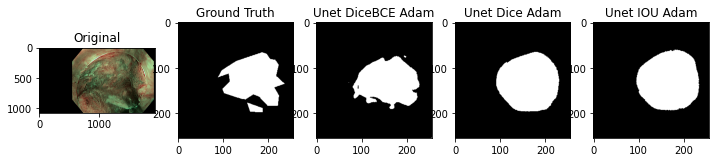

JS_Unet_DiceBCE_Adam: 0.2368
JS_Unet_Dice_Adam: 0.5541
JS_Unet_IOU_Adam: 0.5177


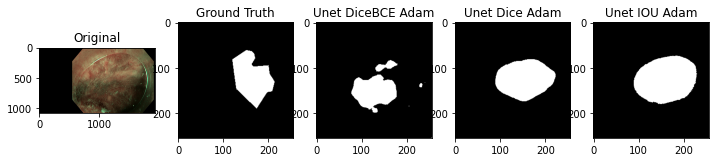

JS_Unet_DiceBCE_Adam: 0.0045
JS_Unet_Dice_Adam: 0.4513
JS_Unet_IOU_Adam: 0.4122


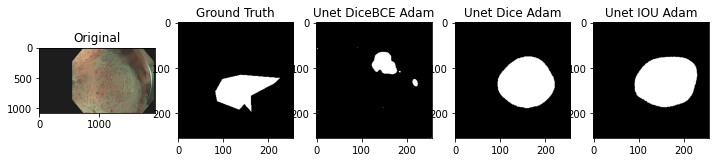

JS_Unet_DiceBCE_Adam: 0.2706
JS_Unet_Dice_Adam: 0.1057
JS_Unet_IOU_Adam: 0.0897


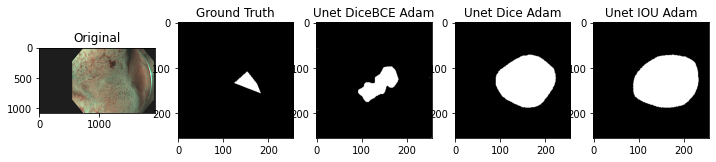

JS_Unet_DiceBCE_Adam: 0.0188
JS_Unet_Dice_Adam: 0.0697
JS_Unet_IOU_Adam: 0.0720


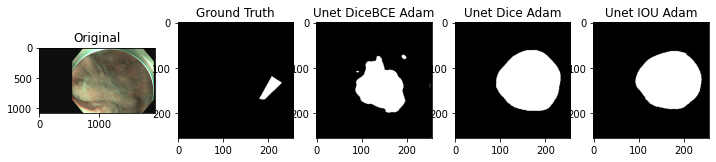

JS_Unet_DiceBCE_Adam: 0.0252
JS_Unet_Dice_Adam: 0.5565
JS_Unet_IOU_Adam: 0.5635


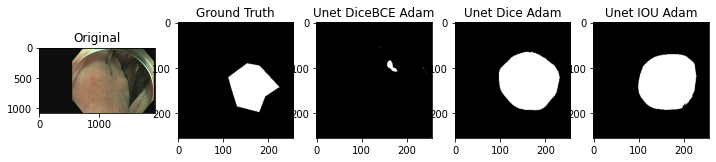

JS_Unet_DiceBCE_Adam: 0.0000
JS_Unet_Dice_Adam: 0.1419
JS_Unet_IOU_Adam: 0.1259


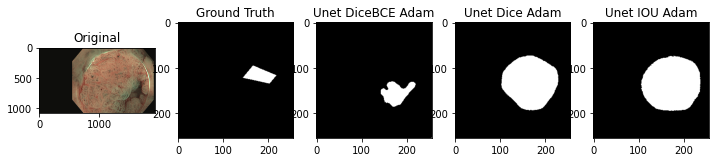

JS_Unet_DiceBCE_Adam: 0.2728
JS_Unet_Dice_Adam: 0.1735
JS_Unet_IOU_Adam: 0.1608


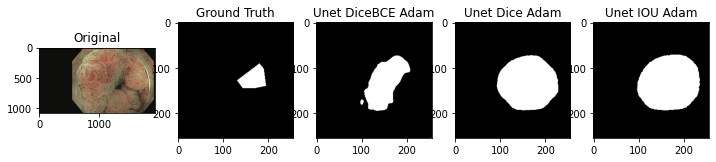

JS_Unet_DiceBCE_Adam: 0.0482
JS_Unet_Dice_Adam: 0.0984
JS_Unet_IOU_Adam: 0.1214


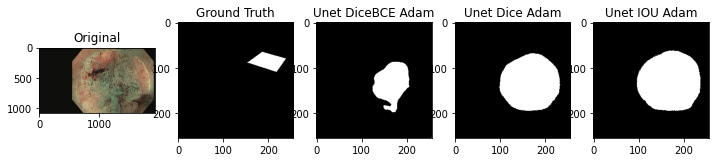

JS_Unet_DiceBCE_Adam: 0.5346
JS_Unet_Dice_Adam: 0.1519
JS_Unet_IOU_Adam: 0.1383


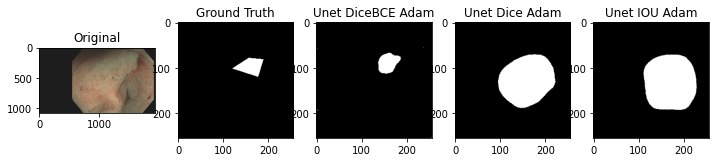

In [ ]:
image_paths = os.listdir(Val_img_folder)
mask_paths = os.listdir(Val_mask_folder)


for idx in range(10):

    img_path = image_paths[idx]
    mask_path = mask_paths[idx]
    img_directory = os.path.join(Val_img_folder, img_path)
    mask_directory = os.path.join(Val_mask_folder, mask_path)


    img = Image.open(img_directory)
    mask = Image.open(mask_directory).convert('1')

    image = img_transforms(img)
    mask = mask_transforms(mask)

    preds_unet_dicebce_adam = predict(image, unet_dicebce_adam, th_unet_dicebce_adam)
    preds_unet_dice_adam = predict(image, unet_dice_adam, th_unet_dice_adam)
    preds_unet_iou_adam = predict(image, unet_iou_adam, th_unet_iou_adam)

    gt = mask.cpu().int().numpy()

    js1 =js(gt, preds_unet_dicebce_adam/255)
    js2 =js(gt, preds_unet_dice_adam/255)
    js3 =js(gt, preds_unet_iou_adam/255)


    print(f"JS_Unet_DiceBCE_Adam: {js1:.4f}")
    print(f"JS_Unet_Dice_Adam: {js2:.4f}")
    print(f"JS_Unet_IOU_Adam: {js3:.4f}")

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols = 5, figsize=(12, 5))

    ax1.imshow(np.array(img))
    ax1.set_title('Original')

    ax2.imshow(np.array(mask)[0, :, :], cmap='gray')
    ax2.set_title('Ground Truth')

    ax3.imshow(preds_unet_dicebce_adam, cmap='gray')
    ax3.set_title('Unet DiceBCE Adam')

    ax4.imshow(preds_unet_dice_adam, cmap='gray')
    ax4.set_title('Unet Dice Adam')

    ax5.imshow(preds_unet_iou_adam, cmap='gray')
    ax5.set_title('Unet IOU Adam')


    plt.subplots_adjust()
    plt.show()